In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time
import time
from memory_profiler import memory_usage
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

In [4]:
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

In [5]:
def pca(adata, use_reps=None, n_comps=10):
    
    """Dimension reduction with PCA algorithm"""
    
    from sklearn.decomposition import PCA
    from scipy.sparse.csc import csc_matrix
    from scipy.sparse.csr import csr_matrix
    pca = PCA(n_components=n_comps,random_state=42)

    if use_reps is not None:
       feat_pca = pca.fit_transform(adata.obsm[use_reps])
    else: 
       if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
          feat_pca = pca.fit_transform(adata.X.toarray()) 
       else:   
          feat_pca = pca.fit_transform(adata.X)
    
    return feat_pca

In [6]:
adata1=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_RNA.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_peaks_normalized.h5ad')
adata1.obs['truth']=adata1.obs['RNA_clusters']
adata2.obs['truth']=adata2.obs['ATAC_clusters']
adata1.var_names_make_unique()
adata2.var_names_make_unique()
sc.pp.filter_genes(adata1, min_cells=10)
sc.pp.filter_cells(adata1, min_genes=200)

sc.pp.highly_variable_genes(adata1, flavor="seurat_v3", n_top_genes=3000)
adata1 =  adata1[:, adata1.var['highly_variable']]
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
adata1.obsm['feat'] = pca(adata1, n_comps=50)

adata2 = adata2[adata1.obs_names].copy()
if 'X_lsi' not in adata2.obsm.keys():
    sc.pp.highly_variable_genes(adata2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata2, use_highly_variable=False, n_components=51)
adata2.obsm['feat'] = adata2.obsm['X_lsi'].copy()

In [7]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X

In [11]:
k=18
graph = prepare_inputs(adata, k, device)
in_channels = graph.features.shape[1]  
out_channels = 25

In [12]:
model = SpatialLocalPooling(in_channels, out_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
@measure_resources
def run_pipeline(adata):
    
    set_seed(7)
    epochs = 400
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        embedding=embedding.cpu().numpy()
        adata.obsm['SpaLP']=embedding
        
run_pipeline(adata=adata)

Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 241.02it/s, Epoch=399, Loss=0.9142]


Function 'run_pipeline' executed in 0.0 minutes and 1.7448 seconds.
Memory usage: 1.62 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 0.34 GB


In [14]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [15]:
adata.obsm['SpaLP']=embedding

In [16]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=18, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

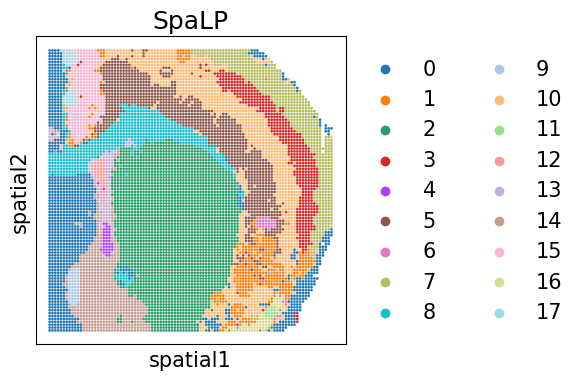

In [17]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['SpaLP'],size=15)

In [18]:
adata4=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset7_Mouse_Brain_ATAC/3d-OT.h5ad')

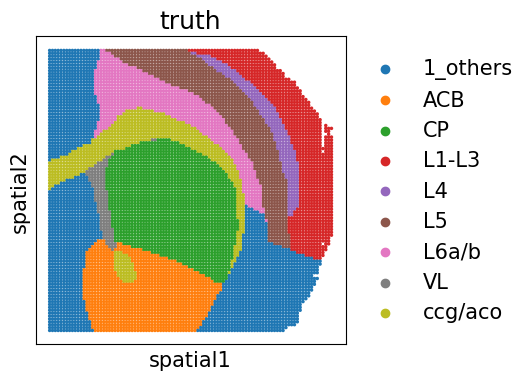

In [19]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata4,basis='spatial',color='truth',size=25,ax=ax)

In [20]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata4.obs['truth'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.4343564511758007
NMI: 0.5691927589659812
AMI: 0.567651980829332
FMI: 0.5160884848823772
V-Measure: 0.5691927589659814
Homogeneity: 0.6122170128724014
